In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import networkx as nx
from collections import defaultdict
import warnings
from typing import Dict, List, Set, Tuple
from math import comb
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# NETWORK DIFFUSION SIMULATION WITH PHYSICAL TIME
# ============================================================================

class NetworkDiffusion:
    """
    Simulate diffusion process on a directed network with physical time units.
    
    Mathematical Model (First-Order ODE):
    -------------------------------------
    For each node i:
        dS_i/dt = -k × S_i + Σ_j (k × S_j / out_degree(j))
    
    where:
        - S_i = substance amount at node i
        - k = diffusion rate [1/time] 
        - Sum is over all nodes j that have edges to i
    
    Numerical Method:
    ----------------
    First-order Forward Euler (explicit):
        S_i(t + Δt) = S_i(t) + Δt × dS_i/dt
    
    Stability condition:
        Δt < 1/k for stability (ideally Δt << 1/k)
    """
    
    def __init__(self, nodes: List[int], edges: List[Tuple[int, int]], 
                 init_state: List[float]):
        """
        Initialize the network diffusion model.
        
        Args:
            nodes: List of node IDs
            edges: List of directed edges (source, target)
            init_state: Initial substance amount at each node (in node order)
        """
        self.nodes = sorted(nodes)
        self.n_nodes = len(nodes)
        
        # Create mapping from node ID to index
        self.node_to_idx = {node: i for i, node in enumerate(self.nodes)}
        self.idx_to_node = {i: node for i, node in enumerate(self.nodes)}
        
        # Build directed graph
        self.G = nx.DiGraph()
        self.G.add_nodes_from(nodes)
        self.G.add_edges_from(edges)
        
        # Store initial state
        self.init_state = np.array(init_state, dtype=float)
        
        # Validate initial state
        if len(self.init_state) != self.n_nodes:
            raise ValueError(f"Initial state length {len(init_state)} doesn't match number of nodes {self.n_nodes}")
        
        # Compute out-degrees for each node
        self.out_degrees = np.array([self.G.out_degree(node) for node in self.nodes])
        
        # Build adjacency information for efficient computation
        self.out_neighbors = {}
        self.in_neighbors = {}
        for node in self.nodes:
            idx = self.node_to_idx[node]
            # Out-neighbors (where substance flows TO)
            out_neighs = list(self.G.successors(node))
            self.out_neighbors[idx] = [self.node_to_idx[n] for n in out_neighs]
            # In-neighbors (where substance flows FROM)
            in_neighs = list(self.G.predecessors(node))
            self.in_neighbors[idx] = [self.node_to_idx[n] for n in in_neighs]
        
        print("Network Diffusion Model Initialized")
        print("=" * 70)
        print(f"Nodes: {self.n_nodes}")
        print(f"Edges: {self.G.number_of_edges()}")
        print(f"Total initial substance: {np.sum(init_state):.2f}")
        print(f"Initial state: {init_state}")
        print("\nNode connectivity:")
        for i, node in enumerate(self.nodes):
            print(f"  Node {node}: {self.out_degrees[i]} out-edges, "
                  f"{len(self.in_neighbors[i])} in-edges")
        print("\nNumerical Method: First-order Forward Euler (explicit)")
    
    def compute_derivatives(self, state: np.ndarray, diffusion_rate: float) -> np.ndarray:
        """
        Compute dS/dt for all nodes.
        
        Args:
            state: Current substance amounts at each node
            diffusion_rate: Diffusion rate k [1/time]
        
        Returns:
            Array of derivatives dS_i/dt for each node
        """
        derivatives = np.zeros(self.n_nodes)
        
        for idx in range(self.n_nodes):
            # Outflow: -k × S_i (if node has out-edges)
            if self.out_degrees[idx] > 0:
                derivatives[idx] -= diffusion_rate * state[idx]
            
            # Inflow: Σ_j (k × S_j / out_degree(j))
            for j in self.in_neighbors[idx]:
                if self.out_degrees[j] > 0:
                    derivatives[idx] += (diffusion_rate * state[j]) / self.out_degrees[j]
        
        return derivatives
    
    def step_forward_euler(self, state: np.ndarray, diffusion_rate: float, 
                          dt: float) -> np.ndarray:
        """
        Perform one step using first-order Forward Euler method.
        
        Args:
            state: Current substance amounts
            diffusion_rate: Diffusion rate k [1/time]
            dt: Time step Δt
        
        Returns:
            New state after time dt
        """
        derivatives = self.compute_derivatives(state, diffusion_rate)
        new_state = state + dt * derivatives
        
        # Ensure non-negative (can have small negative values due to numerical errors)
        new_state = np.maximum(new_state, 0.0)
        
        return new_state
    
    def check_stability(self, diffusion_rate: float, dt: float) -> Tuple[bool, float]:
        """
        Check stability condition for Forward Euler method.
        
        For this system, a rough stability criterion is:
            Δt < 1 / (k × max_out_degree)
        
        Args:
            diffusion_rate: Diffusion rate k [1/time]
            dt: Time step Δt
        
        Returns:
            (is_stable, recommended_dt)
        """
        max_out_degree = np.max(self.out_degrees)
        if max_out_degree == 0:
            return True, dt
        
        # Conservative stability limit
        dt_max = 0.5 / (diffusion_rate * max_out_degree)
        is_stable = dt <= dt_max
        
        return is_stable, dt_max
    
    def simulate(self, diffusion_rate: float, dt: float, 
                 max_time: float = None, max_steps: int = 100000,
                 convergence_threshold: float = 1e-6, 
                 check_interval: int = 100) -> Dict:
        """
        Simulate the diffusion process until convergence.
        
        Args:
            diffusion_rate: Diffusion rate k [1/second]
            dt: Time step Δt [seconds]
            max_time: Maximum simulation time [seconds] (if None, use max_steps)
            max_steps: Maximum number of steps
            convergence_threshold: Stop when max change < this value
            check_interval: Check convergence every N steps
        
        Returns:
            Dictionary with simulation results
        """
        print("\n" + "=" * 70)
        print("STARTING DIFFUSION SIMULATION")
        print("=" * 70)
        print(f"Diffusion rate (k): {diffusion_rate} [1/s]")
        print(f"Time step (Δt): {dt} [s]")
        
        # Check stability
        is_stable, dt_recommended = self.check_stability(diffusion_rate, dt)
        if not is_stable:
            print(f"\n⚠ WARNING: Time step may be too large for stability!")
            print(f"  Current Δt: {dt}")
            print(f"  Recommended Δt < {dt_recommended:.6f}")
            print(f"  Consider reducing time step for numerical stability.")
        else:
            print(f"✓ Stability check passed (Δt < {dt_recommended:.6f})")
        
        if max_time is not None:
            max_steps = min(max_steps, int(np.ceil(max_time / dt)))
            print(f"Max simulation time: {max_time} [s]")
        
        print(f"Max steps: {max_steps}")
        print(f"Convergence threshold: {convergence_threshold}")
        print(f"Check interval: {check_interval}")
        
        # Initialize tracking
        state = self.init_state.copy()
        history = [state.copy()]
        time_history = [0.0]
        total_substance_history = [np.sum(state)]
        
        converged = False
        converged_step = None
        converged_time = None
        
        # Run simulation
        current_time = 0.0
        for step in range(1, max_steps + 1):
            # Perform one time step
            new_state = self.step_forward_euler(state, diffusion_rate, dt)
            current_time += dt
            
            history.append(new_state.copy())
            time_history.append(current_time)
            total_substance_history.append(np.sum(new_state))
            
            # Check convergence periodically
            if step % check_interval == 0:
                max_change = np.max(np.abs(new_state - state))
                total_substance = np.sum(new_state)
                
                if step % (check_interval * 10) == 0 or step == check_interval:
                    print(f"  Step {step:6d} (t={current_time:8.2f}s): "
                          f"max_change={max_change:.2e}, total={total_substance:.2f}")
                
                # Check if converged
                if max_change < convergence_threshold:
                    converged = True
                    converged_step = step
                    converged_time = current_time
                    print(f"\n✓ CONVERGED at step {step} (t={current_time:.2f}s)")
                    print(f"  Max change: {max_change:.2e}")
                    print(f"  Total substance: {total_substance:.2f}")
                    break
            
            state = new_state
        
        if not converged:
            print(f"\n⚠ Did not converge after {max_steps} steps (t={current_time:.2f}s)")
            max_change = np.max(np.abs(history[-1] - history[-2]))
            print(f"  Final max change: {max_change:.2e}")
        
        # Convert history to array
        history_array = np.array(history)
        time_array = np.array(time_history)
        
        # Final statistics
        final_state = history_array[-1]
        total_final = np.sum(final_state)
        total_initial = np.sum(self.init_state)
        
        print("\n" + "=" * 70)
        print("SIMULATION RESULTS")
        print("=" * 70)
        print(f"Total steps: {len(history) - 1}")
        print(f"Total time: {current_time:.2f} seconds")
        print(f"Converged: {converged}")
        print(f"Numerical method: First-order Forward Euler")
        print(f"Total substance conserved: {np.isclose(total_initial, total_final, rtol=1e-3)}")
        print(f"  Initial: {total_initial:.4f}")
        print(f"  Final:   {total_final:.4f}")
        print(f"  Error:   {abs(total_final - total_initial):.2e} "
              f"({abs(total_final - total_initial)/total_initial*100:.4f}%)")
        
        print("\nFinal steady state:")
        for i, node in enumerate(self.nodes):
            print(f"  Node {node}: {final_state[i]:8.2f} ({final_state[i]/total_final*100:5.2f}%)")
        
        return {
            'history': history_array,
            'time': time_array,
            'total_substance_history': np.array(total_substance_history),
            'final_state': final_state,
            'converged': converged,
            'converged_step': converged_step,
            'converged_time': converged_time,
            'total_steps': len(history) - 1,
            'total_time': current_time,
            'diffusion_rate': diffusion_rate,
            'dt': dt
        }
    
    def plot_results(self, results: Dict, save_path: str = None):
        """
        Create comprehensive visualization of diffusion results.
        
        Args:
            results: Dictionary returned by simulate()
            save_path: Optional path to save the figure
        """
        history = results['history']
        time = results['time']
        total_substance_history = results['total_substance_history']
        final_state = results['final_state']
        converged_time = results['converged_time']
        diffusion_rate = results['diffusion_rate']
        dt = results['dt']
        
        # Create figure with subplots
        fig = plt.figure(figsize=(12, 10))
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
        
        # Define colors for each node
        colors = plt.cm.tab10(np.linspace(0, 1, self.n_nodes))
        
        # ====================================================================
        # Plot 1: Substance amount over TIME (linear scale)
        # ====================================================================
        ax1 = fig.add_subplot(gs[0, :])
        
        for i, node in enumerate(self.nodes):
            ax1.plot(time, history[:, i], label=f'Node {node}', 
                    linewidth=2, color=colors[i], alpha=0.8)
        
        if converged_time is not None:
            ax1.axvline(x=converged_time, color='red', linestyle='--', 
                       linewidth=2, alpha=0.5, label='Convergence')
        
        ax1.set_xlabel('Time [seconds]', fontsize=12)
        ax1.set_ylabel('Substance Amount', fontsize=12)
        ax1.set_title(f'Diffusion Dynamics (k={diffusion_rate} unit/s, Δt={dt} s)', 
                     fontsize=14, fontweight='bold')
        ax1.legend(loc='best', fontsize=10, ncol=2)
        ax1.grid(True, alpha=0.3)
        
        # ====================================================================
        # Plot 2: Substance amount over time (log scale for early dynamics)
        # ====================================================================
        ax2 = fig.add_subplot(gs[1, 0])
        
        for i, node in enumerate(self.nodes):
            # Only plot if node has any substance
            if np.max(history[:, i]) > 0:
                ax2.semilogy(time, history[:, i], label=f'Node {node}', 
                            linewidth=2, color=colors[i], alpha=0.8)
        
        if converged_time is not None:
            ax2.axvline(x=converged_time, color='red', linestyle='--', 
                       linewidth=2, alpha=0.5, label='Convergence')
        
        ax2.set_xlabel('Time [seconds]', fontsize=12)
        ax2.set_ylabel('Substance Amount (log scale)', fontsize=12)
        ax2.set_title('Diffusion Dynamics (Log Scale)', fontsize=12, fontweight='bold')
        ax2.legend(loc='best', fontsize=9, ncol=2)
        ax2.grid(True, alpha=0.3, which='both')
        
        # ====================================================================
        # Plot 3: Final steady state (bar chart)
        # ====================================================================
        ax3 = fig.add_subplot(gs[1, 1])
        
        bars = ax3.bar([str(node) for node in self.nodes], final_state, 
                      color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        
        ax3.set_xlabel('Node', fontsize=12)
        ax3.set_ylabel('Substance Amount', fontsize=12)
        ax3.set_title('Steady State Distribution', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, value in zip(bars, final_state):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.1f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # # ====================================================================
        # # Plot 4: Total substance conservation
        # # ====================================================================
        # ax4 = fig.add_subplot(gs[2, 0])
        
        # ax4.plot(time, total_substance_history, linewidth=2, color='blue')
        # ax4.axhline(y=total_substance_history[0], color='red', linestyle='--', 
        #            linewidth=2, label='Initial Total')
        
        # if converged_time is not None:
        #     ax4.axvline(x=converged_time, color='green', linestyle='--', 
        #                linewidth=2, alpha=0.5, label='Convergence')
        
        # ax4.set_xlabel('Time [seconds]', fontsize=12)
        # ax4.set_ylabel('Total Substance', fontsize=12)
        # ax4.set_title('Conservation Check', fontsize=12, fontweight='bold')
        # ax4.legend(loc='best', fontsize=10)
        # ax4.grid(True, alpha=0.3)
        
        # # Calculate and display error
        # error_pct = abs(total_substance_history[-1] - total_substance_history[0]) / total_substance_history[0] * 100
        # ax4.text(0.02, 0.02, f'Error: {error_pct:.4f}%', 
        #         transform=ax4.transAxes, fontsize=10,
        #         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        
        # # ====================================================================
        # # Plot 5: Network structure with steady state node sizes
        # # ====================================================================
        # ax5 = fig.add_subplot(gs[2, 1])
        
        # # Compute node positions
        # pos = nx.spring_layout(self.G, seed=42, k=0.5)
        
        # # Scale node sizes by substance amount
        # node_sizes = final_state / np.max(final_state) * 2000 + 300
        
        # # Draw network
        # nx.draw_networkx_nodes(self.G, pos, node_size=node_sizes, 
        #                       node_color=colors[:self.n_nodes], 
        #                       alpha=0.7, ax=ax5)
        # nx.draw_networkx_labels(self.G, pos, font_size=12, 
        #                        font_weight='bold', ax=ax5)
        # nx.draw_networkx_edges(self.G, pos, edge_color='gray', 
        #                       arrows=True, arrowsize=20, 
        #                       width=2, alpha=0.5, ax=ax5,
        #                       connectionstyle='arc3,rad=0.1')
        
        # ax5.set_title('Network Structure\n(Node size ~ steady state amount)', 
        #              fontsize=12, fontweight='bold')
        # ax5.axis('off')
        
        # Overall title
        method_info = f'First-order Forward Euler, k={diffusion_rate} unit/s, Δt={dt}s'
        fig.suptitle(f'Network Diffusion Analysis\n{method_info}',
                    fontsize=16, fontweight='bold', y=0.995)
        
        if save_path:
            plt.savefig(save_path, dpi=500, bbox_inches='tight')
            print(f"\nPlot saved: {save_path}")
        
        plt.show()
    
    def compare_time_steps(self, diffusion_rate: float, 
                          time_steps: List[float], max_time: float = 100):
        """
        Compare numerical stability and accuracy for different time steps.
        
        Args:
            diffusion_rate: Diffusion rate k [1/s]
            time_steps: List of time steps to compare
            max_time: Maximum simulation time
        """
        print("\n" + "=" * 70)
        print("COMPARING DIFFERENT TIME STEPS (Δt)")
        print("=" * 70)
        print(f"Diffusion rate: {diffusion_rate} [1/s]")
        
        results_dict = {}
        
        for dt in time_steps:
            print(f"\n--- Simulating with Δt = {dt} s ---")
            try:
                results = self.simulate(diffusion_rate, dt, max_time=max_time,
                                      convergence_threshold=1e-6)
                results_dict[dt] = results
            except Exception as e:
                print(f"  ✗ Simulation failed: {e}")
                results_dict[dt] = None
        
        # Plot comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        colors_dt = plt.cm.viridis(np.linspace(0, 1, len(time_steps)))
        
        # Plot 1: Time evolution for different Δt
        ax = axes[0, 0]
        for i, dt in enumerate(time_steps):
            if results_dict[dt] is not None:
                results = results_dict[dt]
                # Plot representative node
                ax.plot(results['time'], results['history'][:, 2], 
                       label=f'Δt={dt}s', linewidth=2, color=colors_dt[i])
        
        ax.set_xlabel('Time [seconds]', fontsize=11)
        ax.set_ylabel('Substance (Node 3)', fontsize=11)
        ax.set_title('Effect of Time Step on Dynamics', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Conservation error
        ax = axes[0, 1]
        for i, dt in enumerate(time_steps):
            if results_dict[dt] is not None:
                results = results_dict[dt]
                initial_total = results['total_substance_history'][0]
                error = np.abs(results['total_substance_history'] - initial_total) / initial_total * 100
                ax.semilogy(results['time'], error, label=f'Δt={dt}s', 
                          linewidth=2, color=colors_dt[i])
        
        ax.set_xlabel('Time [seconds]', fontsize=11)
        ax.set_ylabel('Conservation Error [%]', fontsize=11)
        ax.set_title('Mass Conservation Error', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, which='both')
        
        # Plot 3: Final state comparison
        ax = axes[1, 0]
        x = np.arange(self.n_nodes)
        width = 0.8 / len([dt for dt in time_steps if results_dict[dt] is not None])
        
        plot_idx = 0
        for i, dt in enumerate(time_steps):
            if results_dict[dt] is not None:
                results = results_dict[dt]
                offset = (plot_idx - len([d for d in time_steps if results_dict[d] is not None])/2 + 0.5) * width
                ax.bar(x + offset, results['final_state'], width, 
                      label=f'Δt={dt}s', color=colors_dt[i], alpha=0.7)
                plot_idx += 1
        
        ax.set_xlabel('Node', fontsize=11)
        ax.set_ylabel('Final Substance Amount', fontsize=11)
        ax.set_title('Steady State Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([str(n) for n in self.nodes])
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Plot 4: Summary table
        ax = axes[1, 1]
        ax.axis('off')
        
        summary_text = "SUMMARY\n" + "="*50 + "\n\n"
        summary_text += f"Diffusion rate: {diffusion_rate} [1/s]\n"
        _, dt_recommended = self.check_stability(diffusion_rate, 1.0)
        summary_text += f"Recommended Δt < {dt_recommended:.4f} s\n\n"
        
        for dt in time_steps:
            results = results_dict[dt]
            summary_text += f"Δt = {dt} s:\n"
            if results is None:
                summary_text += "  Status: FAILED (unstable)\n"
            else:
                is_stable, _ = self.check_stability(diffusion_rate, dt)
                summary_text += f"  Stable: {is_stable}\n"
                summary_text += f"  Steps: {results['total_steps']}\n"
                summary_text += f"  Time: {results['total_time']:.2f} s\n"
                error = abs(results['total_substance_history'][-1] - 
                          results['total_substance_history'][0])
                summary_text += f"  Error: {error:.2e}\n"
            summary_text += "\n"
        
        ax.text(0.05, 0.95, summary_text, transform=ax.transAxes,
               fontsize=9, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.tight_layout()
        plt.savefig('diffusion_timestep_comparison.pdf', dpi=500, bbox_inches='tight')
        print("\nComparison plot saved: diffusion_timestep_comparison.pdf")
        plt.show()



Network Diffusion Model Initialized
Nodes: 7
Edges: 12
Total initial substance: 2000.00
Initial state: [1000, 1000, 0, 0, 0, 0, 0]

Node connectivity:
  Node 1: 2 out-edges, 0 in-edges
  Node 2: 2 out-edges, 0 in-edges
  Node 3: 4 out-edges, 3 in-edges
  Node 4: 4 out-edges, 3 in-edges
  Node 5: 0 out-edges, 2 in-edges
  Node 6: 0 out-edges, 2 in-edges
  Node 7: 0 out-edges, 2 in-edges

Numerical Method: First-order Forward Euler (explicit)

EXAMPLE 1: BASIC SIMULATION

STARTING DIFFUSION SIMULATION
Diffusion rate (k): 0.1 [1/s]
Time step (Δt): 0.5 [s]
✓ Stability check passed (Δt < 1.250000)
Max simulation time: 200 [s]
Max steps: 400
Convergence threshold: 1e-06
Check interval: 100
  Step    100 (t=   50.00s): max_change=2.16e+00, total=2000.00

⚠ Did not converge after 400 steps (t=200.00s)
  Final max change: 3.55e-05

SIMULATION RESULTS
Total steps: 400
Total time: 200.00 seconds
Converged: False
Numerical method: First-order Forward Euler
Total substance conserved: True
  Initial

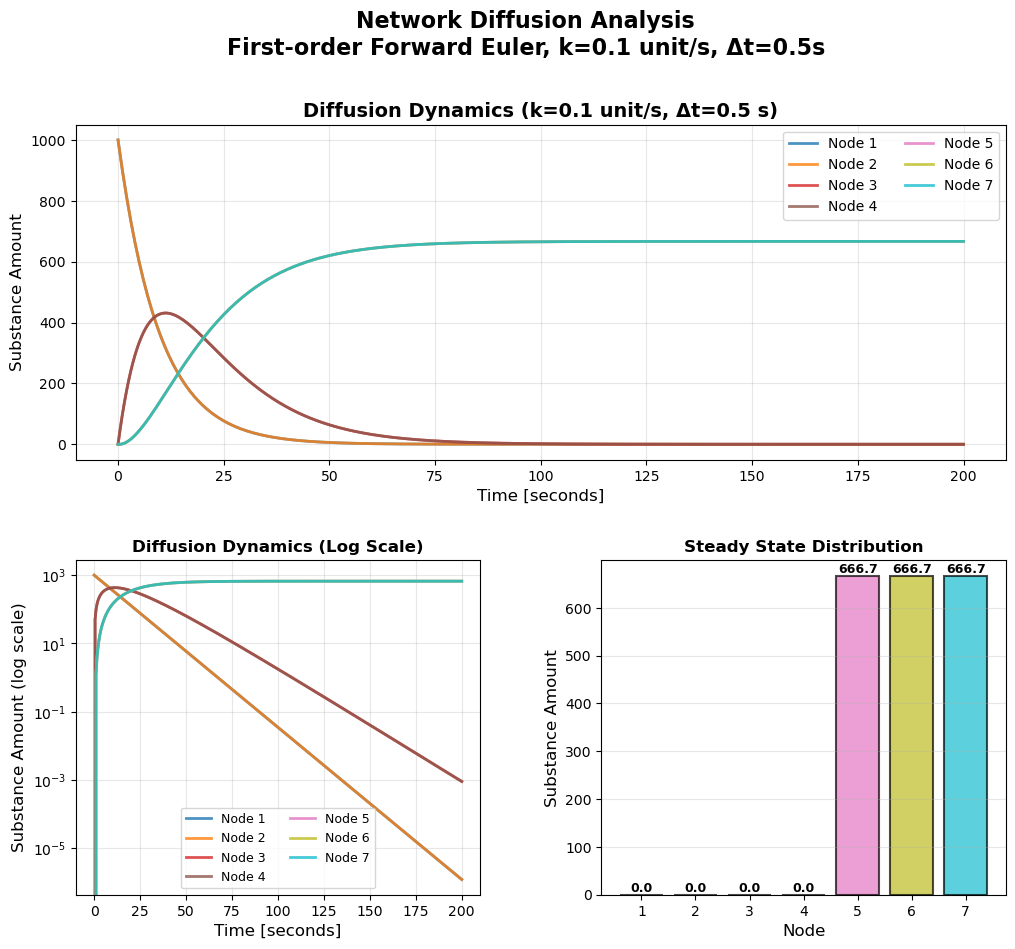

In [3]:
"""
Run diffusion simulation with physical time units.
"""
# Network specification
nodes = [1, 2, 3, 4, 5, 6, 7]
edges = [(1,3), (1,4), (2,3), (2,4), (3,4), (3,5), (3,6), (3,7), 
            (4,3), (4,5), (4,6), (4,7)]
init_state = [1000, 1000, 0, 0, 0, 0, 0]

# Create diffusion model
diffusion = NetworkDiffusion(nodes, edges, init_state)

# ========================================================================
# Example 1: Single simulation with specified parameters
# ========================================================================
print("\n" + "="*70)
print("EXAMPLE 1: BASIC SIMULATION")
print("="*70)

diffusion_rate = 0.1  # k = 0.1 [unit/s]
dt = 0.5              # Δt = 0.5 [s]

results = diffusion.simulate(
    diffusion_rate=diffusion_rate,
    dt=dt,
    max_time=200,  # Run for 200 seconds
    convergence_threshold=1e-6,
    check_interval=100
)

diffusion.plot_results(results, save_path=f'diffusion_k{diffusion_rate}_dt{dt}.pdf')




In [ ]:
# ========================================================================
# Example 2: Compare different time steps for stability analysis
# ========================================================================
print("\n" + "="*70)
print("EXAMPLE 2: TIME STEP COMPARISON")
print("="*70)

diffusion_rate = 0.1  # k = 0.1 [1/s]
time_steps = [0.1, 0.5, 1.0, 2.0]  # Different Δt values

diffusion.compare_time_steps(diffusion_rate, time_steps, max_time=100)

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)